In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
from collections import Counter

In [2]:
dump_file = '/home/nico/.pyrec_data/dumps/161017-15h46m41-KNNBasic'  # launch 
dump = pickle.load(open(dump_file, 'rb'))['fold_0']

df = pd.DataFrame(dump['predictions'], columns=['uid', 'iid', 'rui', 'est', 'wasImpossible'])
# add the error column
df['err'] = abs(df.est - df.rui)
# add the |I_u| and |U_i| columns
df['I_u'] = df.uid.apply(lambda uid: len(dump['trainset'].ur[uid]))
df['U_i'] = df.iid.apply(lambda iid: len(dump['trainset'].ir[iid]))
df[:3]

,uid,iid,rui,est,wasImpossible,err,I_u,U_i
0,64,26,3.0,3.649495,{'was_impossible': False},0.649495,233,168
1,177,831,3.0,3.175855,{'was_impossible': False},0.175855,125,99
2,76,4,4.0,3.325020,{'was_impossible': False},0.674980,81,128


In [3]:
# let's take a look at predictions where error is very low
best_preds = df.sort_values(by='err')[:10]
best_preds

,uid,iid,rui,est,wasImpossible,err,I_u,U_i
7022,744,1420,4.0,4.0,{'was_impossible': False},0.0,27,3
2399,28,1186,1.0,1.0,{'was_impossible': False},0.0,583,2
11879,145,1474,1.0,1.0,{'was_impossible': False},0.0,140,3
16688,505,1474,1.0,1.0,{'was_impossible': False},0.0,140,3
6717,28,889,1.0,1.0,{'was_impossible': False},0.0,583,2
1292,244,1551,3.0,3.0,{'was_impossible': False},0.0,144,1
6046,303,1262,1.0,1.0,{'was_impossible': False},0.0,532,4
12445,411,1618,4.0,4.0,{'was_impossible': False},0.0,87,1
3748,303,1379,1.0,1.0,{'was_impossible': False},0.0,532,3
16882,453,1467,2.0,2.0,{'was_impossible': False},0.0,179,1


These are actually lucky shots: $|U_i|$ is always very low, meaning that very few users have rated the target item. This implies that the set of elligible neighbors is very small... And, it just happens that all the ratings from the neighbors are the same (and mostly, are equal to that of the target user). Not convinced ? try that:

In [5]:
def std_dev(ratings):
    """Return standard deviation of ratings contained in a list of (id, rating) tuples."""
    return np.std([r for (_, r) in ratings])
    
best_preds.iid.apply(lambda x:std_dev(dump['trainset'].ir[x]))

7022     0.0
2399     0.0
11879    0.0
16688    0.0
6717     0.0
1292     0.0
6046     0.0
12445    0.0
3748     0.0
16882    0.0
Name: iid, dtype: float64

In [6]:
# Now, let's take a look at predictions where error is very high
worst_preds = df.sort_values(by='err')[-10:]
worst_preds

,uid,iid,rui,est,wasImpossible,err,I_u,U_i
10701,24,1339,1.0,4.507309,{'was_impossible': False},3.507309,244,4
4534,28,1177,1.0,4.518146,{'was_impossible': False},3.518146,583,2
17116,386,325,1.0,4.526533,{'was_impossible': False},3.526533,121,229
12016,28,1395,1.0,4.568176,{'was_impossible': False},3.568176,583,5
17502,548,402,1.0,4.599840,{'was_impossible': False},3.599840,396,215
2661,465,1395,1.0,4.609239,{'was_impossible': False},3.609239,56,5
15129,184,402,1.0,4.645398,{'was_impossible': False},3.645398,71,215
6414,62,1621,5.0,1.000000,{'was_impossible': False},4.000000,286,1
2199,17,1526,1.0,5.000000,{'was_impossible': False},4.000000,68,1
18434,267,1069,5.0,1.000000,{'was_impossible': False},4.000000,368,1


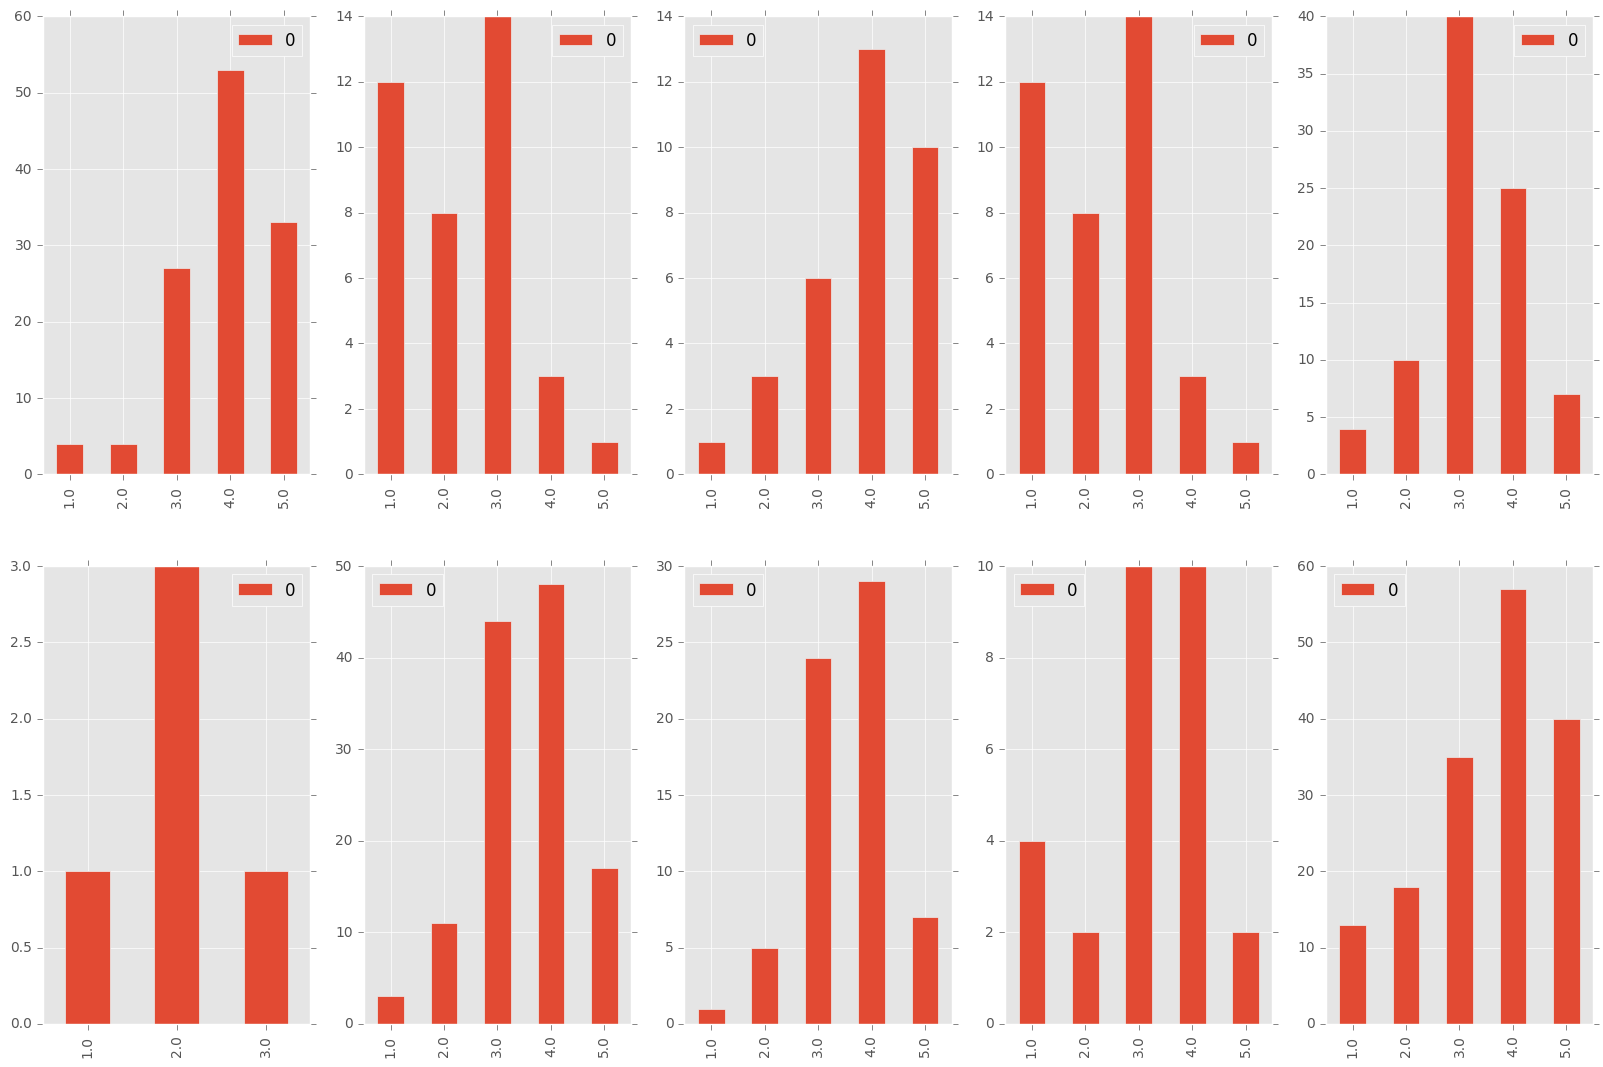

In [9]:
def plot_ratings(ratings, ax):
    counter = Counter([r for (_, r) in ratings])
    pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', ax=ax)

fig = plt.figure(figsize=(20, 13))
for i, iid in enumerate(worst_preds.uid):
    ax = plt.subplot2grid((2,5),(i//5,i%5))
    plot_ratings(dump['trainset'].ir[iid], ax)

Conclusion? Well, when $\hat{r}_{ui} = 1$ and very few users have rated $i$ to $1$, it's difficult for an algorithm to predict it...